# Inspect-study_v2.ipynb

This notebook enables some simple visualization of the data contained in a given datasheet within the vgp database.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from scripts.auxiliar import get_files_in_directory, spherical2cartesian, cartesian2spherical, GCD_cartesian
pd.set_option('display.max_columns', None)

### Displaying all the .xlsx files in the vgp_database folder

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

csv_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.csv')] #consider just *csv files
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] #consider just *csv files
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

,name_xlsx
0,Absaroka_volcanics
1,Beaver_River_intrusions
2,Bighorn_Basin_sediments
3,Bishop_tuff
4,Bitterroot_Dome_intrusions
5,Central_Mexico_Plio-Pleistocene
6,Clear_Lake_volcanic_field
7,Coso_Range_volcanics
8,Dinan_Bay_lavas
9,Eastern_Alkaline_Province


### Select by index the file you want to display

In [3]:
index = 0

#### Separate the *.xlsx file into two different DFs, `df_vgps` and `df_poles`. 
Note: the the number of lines to be skip is harcoded

In [4]:
df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True
df_poles = pd.read_excel(df_files['path'][index], 
                         skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                         nrows  = df[df.isnull().all(1)].index[1] -3)

df_vgps = pd.read_excel(df_files['path'][index], 
                        skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

#cast columns
df_vgps = df_vgps.astype({'in_study_pole': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "VGP_lat":float, "VGP_lon":float
                         })
df_poles = df_poles.astype({'N': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "Plat":float, "Plon":float})

## We then proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 1. In a previous step, we have calculated the site coordinates of all studies in which these coordinates were not reported, but the Dec/Inc and Plat/Plon were. 
 1. When VGP coordinates are reported in the original manuscript (`df_vgps['VGP_lat']` and `df_vgps['VGP_lon']`), we take them as face value 

In [5]:
# redundant, but plain to see.
df_vgps['VGP_lon'] = df_vgps['VGP_lon']
df_vgps['VGP_lat'] = df_vgps['VGP_lat']

 2. When VGP coordinates are NOT reported in the original manuscript but the dec/inc and location of the sites was, we calculate them, and take them as face value.

In [6]:
df_vgps['VGP_lon'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0] if (np.isnan(row.VGP_lon) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lon, axis =1) 
df_vgps['VGP_lat'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1] if (np.isnan(row.VGP_lat) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lat, axis =1) 

## Check polarity of VGPs against directions
 3. Some sites report the backward VGP (so that the VGPs are in the same hemisphere/closer to the principal component). We proceed to check polarity of VGPs against directions. To do that, we recalculate the vgps from the original Dec/Inc.

In [7]:
#First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1) 
df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)

 4. Check distance (`df_vgps['GCD_vgps']`) between the reported VGPs and the recalculated from the directions.

In this step we fill the column `df_vgps['coherent_vgps']` with the following 
- False if inconsistent combination of site coordinates + dec/inc + vgp data (+- 2 degrees away from the reported or its backward)
- True if correct
- np.nan if inverted

In [9]:
df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

# False if Spourious, True if correct, nan if inverted
df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: False if (row.GCD_vgps > np.radians(2) and row.GCD_vgps < np.radians(178)) else (True if row.GCD_vgps < np.radians(2) else np.nan ), axis =1) #True if it is ok, nan 

### Catch some exceptions:
 - Missing slat/slon and/or dec/in where no vgp is reported
 - Missing dec/inc and/or vgp where no site coordinates are reported; cannot calculate site locations.
 - Inconsistent combination of site coordinates + dec/inc + vgp
 - Recalculated VGP was inverted. 

In [10]:
if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) &
               (df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
                  
# if (((df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna())).any()):
#     index = df_vgps['slat'].index[df_vgps['slat'].apply(np.isnan)]
    print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
    print (f"")
    
if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
    
#if (((df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())).any()):
    print(f" => Missing dec/inc and/or vgp in sites: {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no site coordinates are reported; cannot calculate site locations")
    print (f"")
    
if not df_vgps[df_vgps['coherent_vgps'] == False].empty:
    print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == False].name.tolist()}")
    print (f"")
# spourious = df_vgps[df_vgps['coherent_vgps'] == False]['name'].unique()
# if len(spourious) != 0: 

if not df_vgps[df_vgps['coherent_vgps'].isna()].empty:
    print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'].isna()].name.tolist()}")
    print (f"")
    
if not df_vgps[df_vgps['coherent_vgps'] == True].empty:
    print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == True].name.tolist()}")
    print (f"")

 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [618.0, 620.0, 622.0, 617.0, 625.0, 'I8']

 => inverted vgp from sites ('name'): [6.0, '7*', 8.0, '33*', '34*', '35*', '36*', '37*', '38*', 39.0, 40.0, '41*', 51.0, '50*', '49*', 48.0, '47*', 31.0, 32.0, 14.0, '13*', 12.0, 11.0, 10.0, 9.0, '4b', '4a', 4.0, '5b', '5a', 5.0, 44.0, '43*', '3b', '3a', 3.0, '2b', '2a', '2*', 1.0, '16b', '16a', 16.0, '15*', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 'Lower Flow mean', 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 55.0, 'Middle Flow mean', 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 'Upper Flow mean', 389.0, 390.0, '389+390 mean', 394.0, 396.0, '618+620 mean', '448+621 mean', 624.0, '617+624+625 mean', 'I1', 'I2', 'I3', 'I4', 'I6', 'I7', 'Independence stock mean', 'I5']

 => Coherent dec/inc in

### Now, for each reported pole from the selected manuscript we iterate through the constituent site-level data and: 
1) cast all vgps into a common polarity and re-compute the Fisher mean
2) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        19       83.5     177.4    10.1
Recomputed paleopole   1.0        19       83.3     177.4    11.1



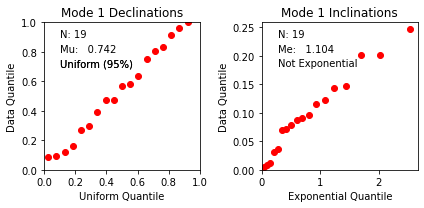

Only one polarity; cannot conduct reversal test
==>Analizing pole 2.
SOMETHING WRONG IN POLE (index): 0, in_situ_pole: 2
==>Analizing pole 3.
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        22       80.8     145.9     8.6
Recomputed paleopole   3.0        22       80.8     145.9     8.6



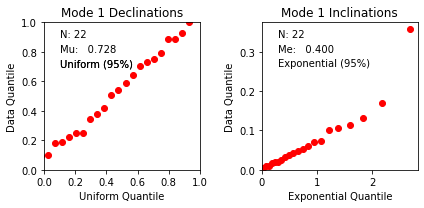

Only one polarity; cannot conduct reversal test


In [12]:
#Groupby iterates through DFs (i) 'grouped by' the variable of interest 
for value, i in df_vgps.groupby(df_vgps['in_study_pole']): 
    # value represent the index and i represent the DF grouped by the variable of interest  
    if value != 0: #discards vgps discarded by authors
               
        print(f"==>Analizing pole {value}.")
        try:
            
            #split vgp population into different polarities by comparison against principal component axis        
            vgp_block = list(zip(i['VGP_lon'].tolist(), i['VGP_lat'].tolist()))
            mode1, mode2 = pmag.separate_directions(di_block=vgp_block)
            #invert one polarity population and merge populations
            if mode2.size == 0: merged = mode1
            else:
                flipped2 = np.delete(np.array(ipmag.do_flip(di_block=mode2)), -1, axis=1)
                merged = np.concatenate((mode1, flipped2))
            pole = df_poles[df_poles['pole'] == value]
            #calculate Fisher mean of merged data
            vgp_mean = ipmag.fisher_mean(di_block=merged)

            print(f"{'' : <20}{'Pole' : ^10}{'N' : ^10}{'Plat' : ^10}{'Plon' : ^10}{'A95' : >5}")        
            print(f"{'Reported paleopole' : <20}{pole.iloc[0]['pole'] : ^10}{pole.iloc[0]['N'] : ^10}{pole.iloc[0]['Plat'] : ^10}{pole.iloc[0]['Plon'] : ^10}{pole.iloc[0]['A95'] : >5}")    
            print(f"{'Recomputed paleopole' : <20}{pole.iloc[0]['pole'] : ^10}{vgp_mean['n'] : ^10}{vgp_mean['inc'] : ^10.1f}{vgp_mean['dec'] : ^10.1f}{vgp_mean['alpha95'] : >5.1f}")
            print(f"")        

            if len(merged) <= 10: print ('Not enough sites to conduct quantile-quantile test')
            else: ipmag.fishqq(di_block=merged)  
            plt.show()
                #reversal test
            if len(mode1) == 0 or len(mode2) == 0: print ('Only one polarity; cannot conduct reversal test')
            elif len(mode1) < 3 or len(mode2) < 3: print ('Not enough sites from one (or both) polarity populations to conduct reversal test')
            else: ipmag.common_mean_bootstrap(mode1, flipped2)
            
        except:
            print(f"SOMETHING WRONG IN POLE (index): {index}, in_situ_pole: {value}")   

# Iterate through all the files to catch exceptions:


========================= ANALYZING : Absaroka_volcanics =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [618.0, 620.0, 622.0, 617.0, 625.0, 'I8']

 => inverted vgp from sites ('name'): [6.0, '7*', 8.0, '33*', '34*', '35*', '36*', '37*', '38*', 39.0, 40.0, '41*', 51.0, '50*', '49*', 48.0, '47*', 31.0, 32.0, 14.0, '13*', 12.0, 11.0, 10.0, 9.0, '4b', '4a', 4.0, '5b', '5a', 5.0, 44.0, '43*', '3b', '3a', 3.0, '2b', '2a', '2*', 1.0, '16b', '16a', 16.0, '15*', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 'Lower Flow mean', 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 55.0, 'Middle Flow mean', 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 'Upper Flow mean', 389.0, 390.0, '389+390 mean', 394.0, 396.0, '618+620 mean', '448+621 mean', 624.0, '617+624+625 mean', 'I1', 'I2',

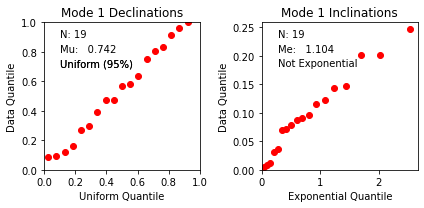

Only one polarity; cannot conduct reversal test
==>Analizing pole 2.
SOMETHING WRONG IN POLE (index): 0, in_situ_pole: 2
==>Analizing pole 3.
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        22       80.8     145.9     8.6
Recomputed paleopole   3.0        22       80.8     145.9     8.6



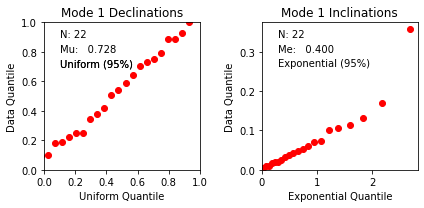

Only one polarity; cannot conduct reversal test

========================= ANALYZING : Beaver_River_intrusions =======================
 => Coherent dec/inc in sites ('name'): ['01 LCE', '02 LCE', '03 LCE', '04 LCE', '05 LCE', '06 LCE', '07 LCE', '08 LCE', '09 LCW*', '10 LCW', '11 LCW', '12 LCW', '13 LCW*', '14 LCW', '16 LCW', '17 LCW*', '18 BR', '19 BR', '20 BR', '21 BR', '22 BR', '23 BR', '24 BR', '25 BR*', '26 BR']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        21       79.2     145.8     nan
Recomputed paleopole   1.0        21       79.3     147.7     4.8



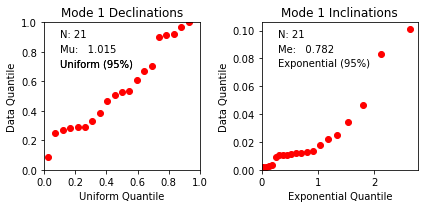

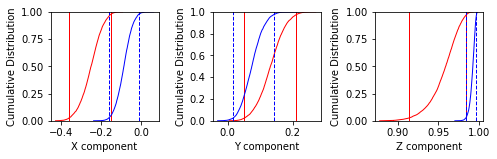


========================= ANALYZING : Bighorn_Basin_sediments =======================
 => Coherent dec/inc in sites ('name'): ['BH0414β', 'BH0401α', 'BH0403α', 'BH0404α', 'BH0405α', 'BH0407α', 'BH0408α', 'BH0410α', 'BH0412β', 'BH02015α', 'BH02016β', 'BH02019β', 'BH02018β', 'BH02020β', 'BH02021β', 'BH0415α', 'BH0416α', 'BH0417α', 'BH0418β', 'BH0419α', 'BH0420α', 'BH0421α', 'BH0422α', 'BH02034α', 'BH02035α', 'BH02037α', 'BH02038α', 'BH02039α', 'BH02040α', 'BH02041α', 'BH02042α', 'BH02043α', 'BH02044α', 'BH0423α', 'BH0424α', 'BH0425α', 'BH0426a', 'BH0427β', 'BH0433β', 'BH01025α', 'BH01027α', 'BH01028α', 'BH01031α', 'BH01033β', 'BH01036β', 'BH01037β', 'BH01038α', 'BH01039α', 'BH01040α', 'BH01041β', 'BH01042β', 'BH01043α', 'BH01045α', 'BH01046α', 'BH01049α', 'BH01050α', 'BH01051α', 'BH01052β', 'BH01053α', 'BH01054β', 'BH01055α', 'BH01056β', 'BH01057β', 'BH01061β', 'BH01064α', 'BH01066β', 'BH01068β', 'BH01071β', 'BH01073α', 'BH01075β', 'BH01076α', 'BH01077α', 'BH01079β', 'BH01080α', 'BH0108

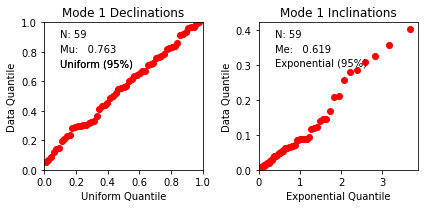

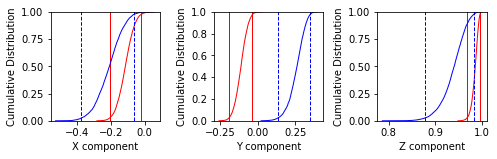


========================= ANALYZING : Bishop_tuff =======================
 => Coherent dec/inc in sites ('name'): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B23', 'B24', 'B25 (0 m)', 'B25 (3 m)', 'B25 (6 m)', 'B25 (9 m)', 'B25 (12 m)', 'B25 (15 m)', 'B25 (18 m)', 'B25 (21 m)', 'B25 (24 m)', 'B25 (27 m)', 'B25 (30 m)', 'B25 (33 m)', 'B26', 'B27', 'C001', 'C041', 'C051', 'C071', 'C615', 'C621', 'C530', 'C538', 'Xen', 'LT', 'Bishop Tuff mean']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        1        nan       nan      nan
SOMETHING WRONG IN POLE (index): 3, in_situ_pole: 1

========================= ANALYZING : Bitterroot_Dome_intrusions =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['B15a', 'S17']

 => Coherent dec/inc in sites ('name'): ['B01', 'B02', 'B03',

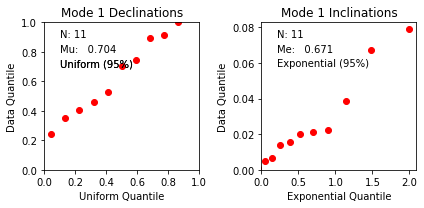

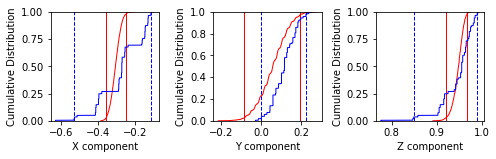

==>Analizing pole 2.
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        8        nan       nan      nan
Recomputed paleopole   2.0        8        68.1     279.2    27.5

Not enough sites to conduct quantile-quantile test


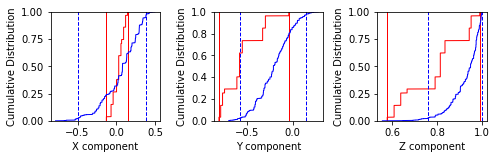


========================= ANALYZING : Central_Mexico_Plio-Pleistocene =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [2.0, 18.0]

 => Coherent dec/inc in sites ('name'): [3.0, 4.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 17.0, 19.0, 20.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        13      -88.8     149.5     5.3
Recomputed paleopole   1.0        13       88.5     331.9     5.3



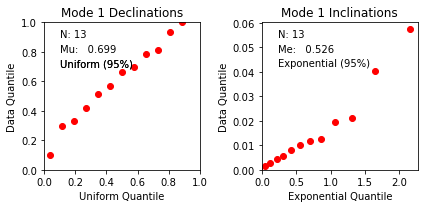

Not enough sites from one (or both) polarity populations to conduct reversal test

========================= ANALYZING : Clear_Lake_volcanic_field =======================
 => inverted vgp from sites ('name'): ['dcv-1', 'dcv-2', 'dcv-3', 'dc-1', 'dc-2', 'ra-1', 'ra-2', 'ra-3', 'ra-4', 'ra-5', 'ra-6', 'rb', 'dh', 'dsb', 'r-1', 'r-2', 'ds', 'dhm-1', 'dhm-2', 'dhm-3', 'dhc', 'dhf', 'aps-1', 'aps-2', 'aps-3', 'aps mean', 'dl', 'ast-1', 'ast-2', 'ac', 'aph', 'asc', 'db-1', 'db-2', 'asf-1', 'asf-2', 'asf-3', 'ag', 'ra-7']

==>Analizing pole 1.
SOMETHING WRONG IN POLE (index): 6, in_situ_pole: 1

========================= ANALYZING : Coso_Range_volcanics =======================
 => inverted vgp from sites ('name'): [58.0, 35.0, 32.0, 33.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        2        nan       nan      nan
Recomputed paleopole   1.0        2        73.8      69.3    66.8

Not enough sites to conduct quantile-

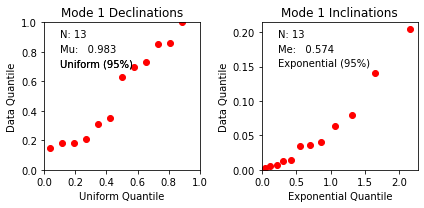

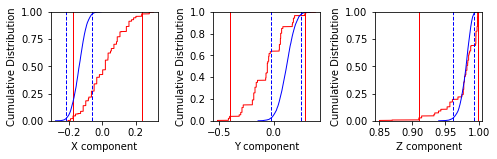


========================= ANALYZING : Eastern_Alkaline_Province =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['VE18', 'VE19', 'VE11', 'VE17']

 => Coherent dec/inc in sites ('name'): ['VE10', 'VE13', 'VE12', 'VE09', 'VE14', 'VE16', 'VE05', 'VE03', 'VE02', 'VE04', 'VE07', 'VE01', 'VE06', 'VE15', 'VE08']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        17       nan       nan      nan
Recomputed paleopole   1.0        17       89.2      78.6     5.7



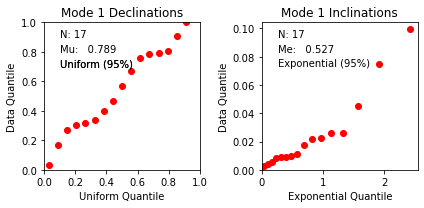

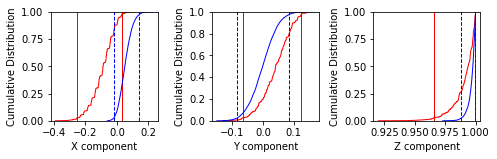


========================= ANALYZING : Eastern_TMVB =======================
 => Coherent dec/inc in sites ('name'): ['SM1', 'SM2*', 'SM3', 'SM4', 'SM5', 'SM6*', 'SM7', 'SM8', 'SM9*', 'SM10*', 'SM11', 'SM12*', 'SM13', 'SM14', 'SM15', 'SM16', 'SM17', 'PS2 (VE34)', 'PS3* (VE71b)', 'PS4 (VE15)', 'PS1 (VE108)', 'CA2', 'MC2', 'MM1', 'XO1 (VE118)', 'CY1 (VE118)', 'MI1 (VE118)', 'MR1* (VE118)', 'JA1 (PH113)', 'TRT (TH24)', 'MO1 (PH171)', 'MZ1 (PH135)', 'ZC1 (PH141)', 'MS2-3 (VE94)', 'ZC2', 'SB1', 'ZC3', 'PL1 (PH62)', 'AT1 (PH40)']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        12       86.8      96.8     6.5
Recomputed paleopole   1.0        12       86.3     116.9     6.8



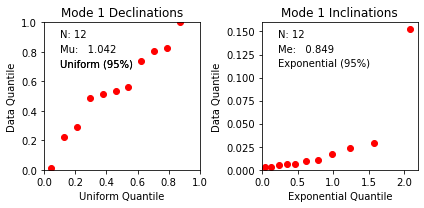

Not enough sites from one (or both) polarity populations to conduct reversal test
==>Analizing pole 2.
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        3        82.1     190.7    18.0
Recomputed paleopole   2.0        3        82.5     180.8    14.3

Not enough sites to conduct quantile-quantile test
Not enough sites from one (or both) polarity populations to conduct reversal test
==>Analizing pole 3.
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        17       80.5     188.1     8.1
Recomputed paleopole   3.0        17       79.8     186.2     8.5



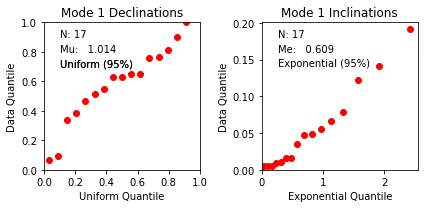

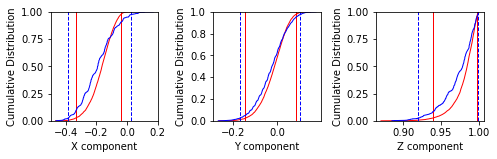


========================= ANALYZING : East_Fork_Basin_sediments =======================

========================= ANALYZING : Latir_volcanic_field =======================
 => inverted vgp from sites ('name'): ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'AS1', 'AS2', 'AS3', 'AS4', 'AS5', 'AS6', 'QL1-2', 'QL2-2', 'QL3-2', 'QL4', 'QL5', 'QL5-2', 'QL6', 'QL7', 'QL7-2', 'QL8', 'QL8-2', 'QL9', 'QL10', 'QL11', 'QL12', 'QL13', 'QL14', 'QL15', 'QL16', 'AT1', 'AT2', 'AT3-2', 'AT4-2', 'AT5-2', 'AT6-2', 'AT7', 'AT8-2', 'AT9', 'AT9-2', 'AT10', 'AT11', 'AT12', 'AT13', 'AT14', 'AT15-2', 'AT16-2', 'AT17', 'AT18', 'AT19', 'AT20', 'AT21', 'AT22', 'Amalia Tuff mean', 'R1', 'R2', 'R3', 'R4', 'R6', 'R8', 'R9', 'R10', 'S1', 'S3', 'AB1', 'AB2', 'SB1', 'RH1', 'RH2', 'RH2-R', 'RH3', 'RH4', 'RH5', 'RH6', 'RH7', 'RH8', 'RH9-R', 'RH10', 'RH11-R', 'RH12', 'RH12-R', 'LP1', 'LP2', 'LP3', 'LP4', 'LP5', 'SG1', 'SG2', 'SG3', 'SG5'

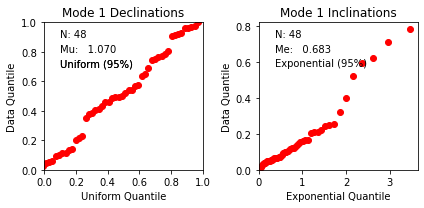

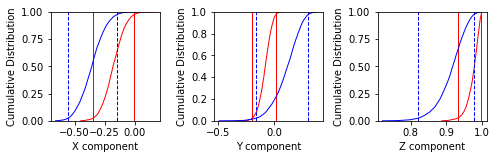

==>Analizing pole 2.
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        43       nan       nan      nan
Recomputed paleopole   2.0        43       82.4     163.1     6.9



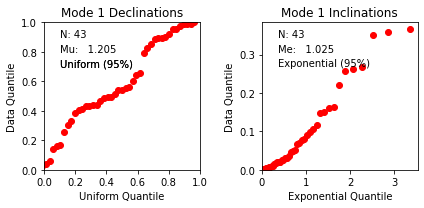

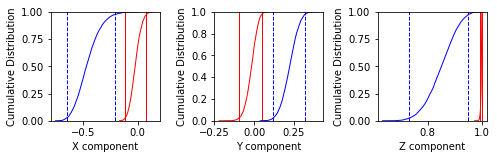


========================= ANALYZING : Long_Valley_Caldera_volcanics =======================
 => inverted vgp from sites ('name'): ['5L209', '5L233', '5L352', '5L452', '5L460', '5L468', '5L344', '5L444', '5L334', '5L385', '5L360', '5L225', '5L201', '5L326', '5L217', '5L258', '5L266', '5L274', '5L313', '5L321', '5L306', '5L290', '5L282', '5L298', '5L420', '5L565', '5L492', '5L484', '5L401', '5L409', '5L476', '5L417', '5L368', '5L377', '5L428', '5L393', '5L241', '5L249', '5L436']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        20       nan       nan      nan
Recomputed paleopole   1.0        20       87.7     191.1     7.5



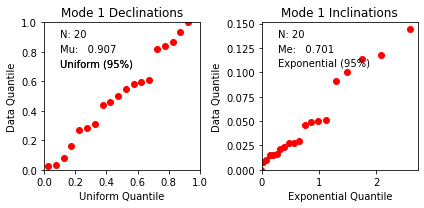

Only one polarity; cannot conduct reversal test

========================= ANALYZING : Mariscal_Mtn_intrusions =======================
 => Coherent dec/inc in sites ('name'): ['mm8', 'mm9', 'mm10', 'mm12', 'mm13', 'mm18', 'mm19*', 'mm20', 'mm21', 'mm22*', 'mm23', 'mm24', 'mm25', 'mm26', 'mm30', 'mm31', 'mm37', 'mm39', 'mm42a', 'mm42b*', 'mm44']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        18       80.0     185.3     5.4
Recomputed paleopole   1.0        18       80.0     185.2     5.4



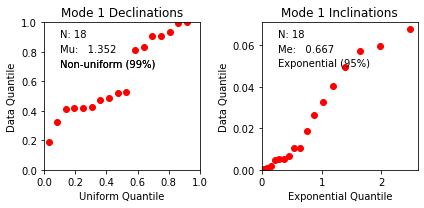

Only one polarity; cannot conduct reversal test

========================= ANALYZING : Michoacan_Guanajuato_volcanic_field =======================
 => Coherent dec/inc in sites ('name'): ['Tan1 (TV)', 'Tan2 (TV)', 'Tan3 (UR-4)', 'Tan5 (Tan28)', 'Tan6 (Tan26)', 'Tan7 (Tan10)', 'Tan8 (Tan43)', 'Tan9 (Tan 43)', 'Tan10 (NI 19)', 'Tan11 (NI 18)']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        8        84.4     219.9     8.5
Recomputed paleopole   1.0        8        83.1     222.7    10.1

Not enough sites to conduct quantile-quantile test
Only one polarity; cannot conduct reversal test

========================= ANALYZING : Mistastin_Lake_impact =======================
 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, '4_adj', '5_adj', 6.0, '7_adj', 8.0, 9.0, 10.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0, 11.0, 10.0, 9.0, 6.0, '6-ani', 7.0, '7-ani', 13.0, 14.0, 15.0, 17.0]

==>Analizing pole 1.
SOMETHING WRONG IN POLE (

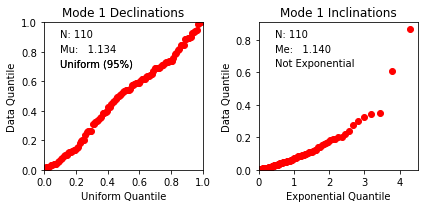

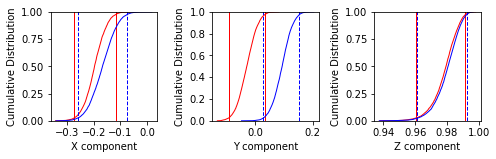


========================= ANALYZING : Monterey_intrusions =======================
 => inverted vgp from sites ('name'): [1.0, 2.0, 3.0, 6.0, 7.0, 8.0]

 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        6        nan       nan      nan
Recomputed paleopole   1.0        6        82.6     235.6    10.2

Not enough sites to conduct quantile-quantile test
Only one polarity; cannot conduct reversal test
==>Analizing pole 2.
SOMETHING WRONG IN POLE (index): 18, in_situ_pole: 2

========================= ANALYZING : N_Montana_intrusions =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['BP40*', 'EB8*', 'SH5*', 'MB-2', 'MB-3', 'MB-4', 'MB-9']

 => inverted vgp from sites ('name'): ['BP4R', 'BP13', 'BP14', 'BP36', 'BP37', 'BP38', 'BP41', 'BP42', 'BP46', 'BP1', 'BP2', 'BP1

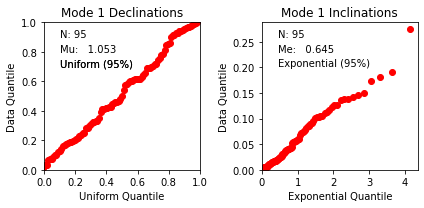

Only one polarity; cannot conduct reversal test

========================= ANALYZING : Ramsay_Island_lavas =======================
 => Coherent dec/inc in sites ('name'): [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 37.0, 38.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        11       78.1     119.9     7.0
Recomputed paleopole   1.0        37       83.3     119.2     5.7



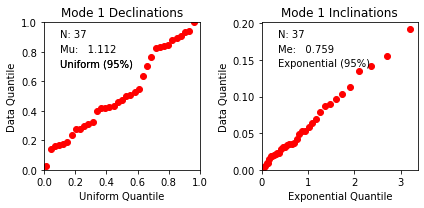

Not enough sites from one (or both) polarity populations to conduct reversal test

========================= ANALYZING : Rattlesnake_Hills_volcanics =======================
 => inverted vgp from sites ('name'): ['A', 'B', 'C', 'D', 'E', 'F*', 'G', 'H', 'I', 'J', 'K*', 'L', 'M', 'N', 'O*', 'P', 'Q', 'R', 'S', 'T', 'U', 'V*']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        18       79.4     146.2     9.6
Recomputed paleopole   1.0        18       79.4     146.1     9.6



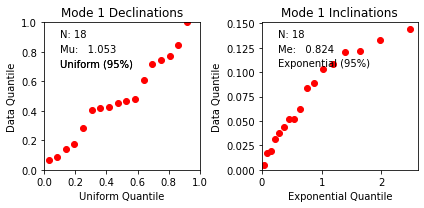

Only one polarity; cannot conduct reversal test

========================= ANALYZING : Robinson_Antincline_intrusions =======================
 => Coherent dec/inc in sites ('name'): [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        16       nan       nan      nan
Recomputed paleopole   1.0        16       77.5     149.8     7.5



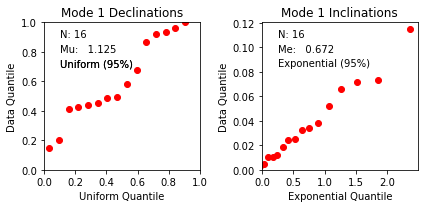

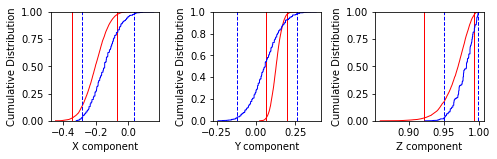


========================= ANALYZING : San_Luis_Hills_volcanics =======================
 => inverted vgp from sites ('name'): [1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        23       79.7     162.6     nan
Recomputed paleopole   1.0        23       79.7     169.5     8.4



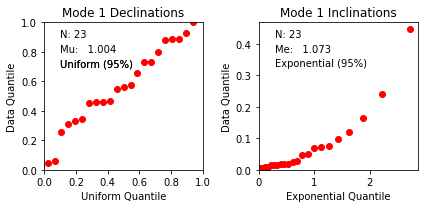

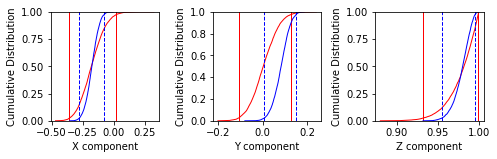


========================= ANALYZING : Sierra_de_Las_Cruces =======================
 => Coherent dec/inc in sites ('name'): ['JQ1', 'JQ2', 'JQ3', 'JQ4', 'CM1*', 'AJ1', 'AJ2', 'IT', 'IT2', 'ST2', 'JI1', 'ST3', 'CR**', 'CR2**', 'PL', 'MT*', 'MT2**', 'ST4', 'ST5', 'ST1', 'AY', 'CH1', 'CH2', 'CH3', 'GU3', 'PC2', 'TO1', 'TO3', 'TO2', 'TO4']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        25      161.8      80.1     4.5
Recomputed paleopole   1.0        25       80.8     156.6     4.7



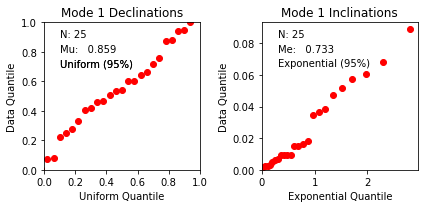

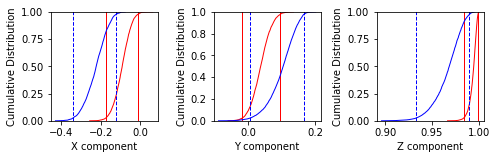


========================= ANALYZING : Snake_River_Plain =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['sr01', 'sr03', 'sr04', 'sr09', 'sr11', 'sr12', 'sr16', 'sr19', 'sr20', 'sr21', 'sr22', 'sr23', 'sr24', 'sr25', 'sr26', 'sr27', 'sr28', 'sr29', 'sr30', 'sr31', 'sr34', 'sr36', 'sr37', 'sr39', 'sr40', 'sr42']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        23       86.9      7.8      6.2
Recomputed paleopole   1.0        23       86.9     229.8     6.2



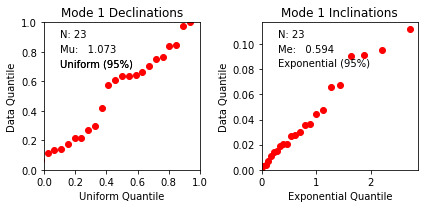

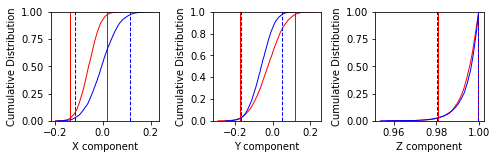


========================= ANALYZING : Sonoma_volcanics =======================
 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 'SV27 (S28)', 'SV26', 'SV25 (S7)', 'SV24 (S6)', 'SV23', 'SV22', 'SV21', 'SV20', 'SV19 (S4, S5)', 'SV18 (S3)', 'SV17 (S2)', 'SV16', 'SV15', 'SV14', 'SV13', 'SV12', 'SV11 (S19)', 'SV10 (S16)', 'SV9', 'SV8 (S15)', 'SV7 (S14)', 'SV6 (S12)', 'SV5 (S11)', 'SV4 (S21)', 'SV3 (S20)', 'SV2', 'SV1']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        25       80.2      69.2     6.8
Recomputed paleopole   1.0        26       80.3      68.9     6.5



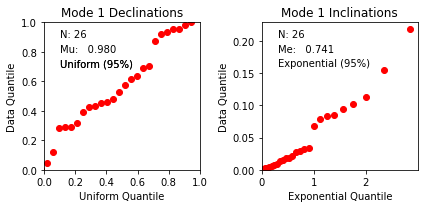

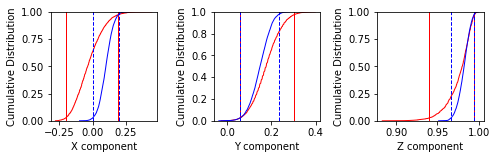


========================= ANALYZING : Stanislaus_Group =======================
 => Missing slat/slon and/or dec/inc from sites ('name'): ['Table Mountain Latite (west) average'] where no vgp is reported; cannot calculate vgp

 => Missing dec/inc and/or vgp in sites: ['Table Mountain Latite (west) average'] where no site coordinates are reported; cannot calculate site locations

 => inverted vgp from sites ('name'): ['Tollhouse Flat Member mean', 'Table Mountain Latite (west) average']

 => Coherent dec/inc in sites ('name'): ['BP5', 'WD4', 'WD7', 'BP7', '3V156', 'LW96', 'Upper Member mean', 'LW93', 'LW23', 'LW92', 'LW95', 'By-Day Member mean', 'BP3', 'LW25', 'LW90', 'LW91', 'LW94', 'LW88', 'LW86', '3V138', '3V129', 'JR', 'WD10', 'MK13', 'LW97', 'DM11', 'DM9', 'DM6', 'DM3', 'DM1', 'MK1', 'PW26', 'RH3', 'WD2', 'LW98', 'RR', 'MC', 'LG']

==>Analizing pole 1.
SOMETHING WRONG IN POLE (index): 27, in_situ_pole: 1

========================= ANALYZING : Stoddard_Mountain_laccolith ===========

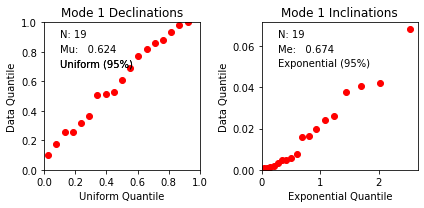

Not enough sites from one (or both) polarity populations to conduct reversal test

========================= ANALYZING : SW_USA_composite =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['1C138*', '3V012*', '3X013', '4D174']

 => Coherent dec/inc in sites ('name'): ['1C614', '1C651', '1C671', '1C684', '1C701', '2C551', '2C801*', '2C804', '3V021', '3V028', '3V038', '3V048', '3V061', '3V077', '1C118', '2C809', '2C821', '2D005', '2D041*', '2D045', '2D051*', '2D056*', '2D066*', '2D072', '3D101', '3D115', '3D131', '3D138', '3V069', '3X209', '3X245', '3X901*', '3X906', '3X914', '3X921', '4D122', '1C601', '2C516*', '2C576', '2C582', '2C591', '2D001*', '3D107', '3V101', '3V121', '3V148', '3X020', '3X031', '3X038', '4D082', '4D090', '4D183', '4D191', '9E224', '3V001', '3V085', '3V093', '3V109', '3V167', '3X001', '5G102*', '5G113*', '5G122*', '5G133', '1C143*', '1C151', '1C160*', '2C508*', '2D010*', '2D018*', '2D025*', '2D031*', '2D036*'

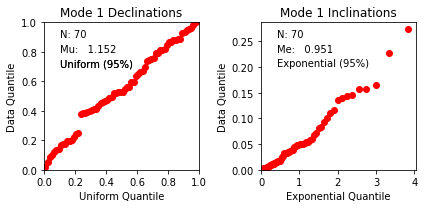

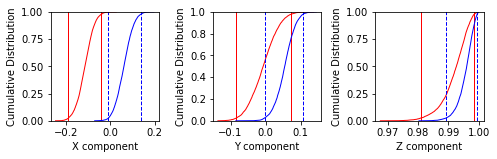


========================= ANALYZING : Tequila_volcanic_field =======================
 => Coherent dec/inc in sites ('name'): ['TL1', 'TL5', 'TM3', 'TM2', 'TM1', 'TM6', 'TM11', 'TM10', 'TM9', 'TL2', 'TL9', 'TM5', 'TM8', 'TL3', 'TL12', 'TL4', 'TL10', 'TL7', 'TL11', 'TM4', 'TM7']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        17       85.8      84.3     6.9
Recomputed paleopole   1.0        17       85.8      84.4     6.9



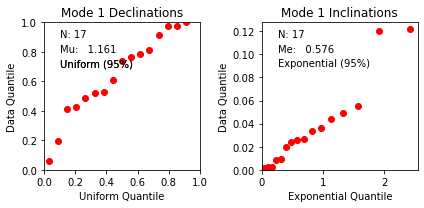

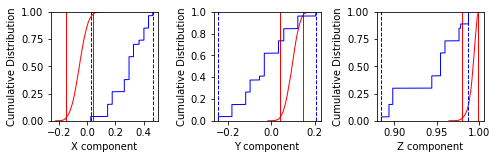


========================= ANALYZING : Valles_Caldera_volcanics =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['S42']

 => Coherent dec/inc in sites ('name'): ['S47', 'S46', 'S45', 'S44', 'S43', 'S41', 'S40', 'S39', 'S38', 'S37', 'S35', 'S34', "Anorthoclase' unit", 5.0, 4.0, 3.0, 2.0, 1.0, 'S31: Upper member mean', 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 'S30: Lower member mean', 'S29']

==>Analizing pole 1.
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        10       nan       nan      nan
Recomputed paleopole   1.0        11       87.1      38.6    13.4



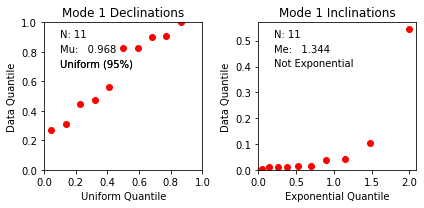

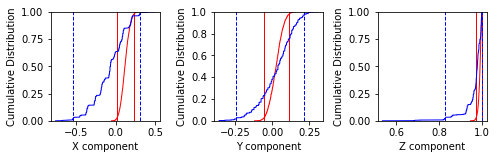


========================= ANALYZING : Washakie_Basin_sediments =======================


In [18]:
for index in range(len(df_files) -1):
    print(f'')
    print(f'========================= ANALYZING : {df_files.name_xlsx[index]} =======================')
    df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True
    df_poles = pd.read_excel(df_files['path'][index], 
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(df_files['path'][index], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "VGP_lat":float, "VGP_lon":float
                             })
    df_poles = df_poles.astype({'N': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "Plat":float, "Plon":float})
    if df_vgps.empty: continue
    # redundant, but plain to see.
    df_vgps['VGP_lon'] = df_vgps['VGP_lon']
    df_vgps['VGP_lat'] = df_vgps['VGP_lat']

    df_vgps['VGP_lon'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0] if (np.isnan(row.VGP_lon) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lon, axis =1) 
    df_vgps['VGP_lat'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1] if (np.isnan(row.VGP_lat) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lat, axis =1) 
    
    #First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
    df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1) 
    df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    
    df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

    # False if Spourious, True if correct, nan if inverted
    df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: False if (row.GCD_vgps > np.radians(2) and row.GCD_vgps < np.radians(178)) else (True if row.GCD_vgps < np.radians(2) else np.nan ), axis =1) #True if it is ok, nan 
    
    if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) &
               (df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
                  
    # if (((df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna())).any()):
    #     index = df_vgps['slat'].index[df_vgps['slat'].apply(np.isnan)]
        print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
                   (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:

    #if (((df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())).any()):
        print(f" => Missing dec/inc and/or vgp in sites: {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no site coordinates are reported; cannot calculate site locations")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == False].empty:
        print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == False].name.tolist()}")
        print (f"")
    # spourious = df_vgps[df_vgps['coherent_vgps'] == False]['name'].unique()
    # if len(spourious) != 0: 

    if not df_vgps[df_vgps['coherent_vgps'].isna()].empty:
        print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'].isna()].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == True].empty:
        print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == True].name.tolist()}")
        print (f"")
    
    for value, i in df_vgps.groupby(df_vgps['in_study_pole']): 
    # value represent the index and i represent the DF grouped by the variable of interest  
        if value != 0: #discards vgps discarded by authors

            print(f"==>Analizing pole {value}.")
            try:
                #split vgp population into different polarities by comparison against principal component axis        
                
                vgp_block = list(zip(i['VGP_lon'].tolist(), i['VGP_lat'].tolist()))
                mode1, mode2 = pmag.separate_directions(di_block=vgp_block)
                #invert one polarity population and merge populations
                if mode2.size == 0: merged = mode1
                else:
                    flipped2 = np.delete(np.array(ipmag.do_flip(di_block=mode2)), -1, axis=1)
                    merged = np.concatenate((mode1, flipped2))
                pole = df_poles[df_poles['pole'] == value]
                #calculate Fisher mean of merged data
                vgp_mean = ipmag.fisher_mean(di_block=merged)

                print(f"{'' : <20}{'Pole' : ^10}{'N' : ^10}{'Plat' : ^10}{'Plon' : ^10}{'A95' : >5}")        
                print(f"{'Reported paleopole' : <20}{pole.iloc[0]['pole'] : ^10}{pole.iloc[0]['N'] : ^10}{pole.iloc[0]['Plat'] : ^10}{pole.iloc[0]['Plon'] : ^10}{pole.iloc[0]['A95'] : >5}")    
                print(f"{'Recomputed paleopole' : <20}{pole.iloc[0]['pole'] : ^10}{vgp_mean['n'] : ^10}{vgp_mean['inc'] : ^10.1f}{vgp_mean['dec'] : ^10.1f}{vgp_mean['alpha95'] : >5.1f}")
                print(f"")        

                if len(merged) <= 10: print ('Not enough sites to conduct quantile-quantile test')
                else: ipmag.fishqq(di_block=merged)  
                plt.show()
                    #reversal test
                if len(mode1) == 0 or len(mode2) == 0: print ('Only one polarity; cannot conduct reversal test')
                elif len(mode1) < 3 or len(mode2) < 3: print ('Not enough sites from one (or both) polarity populations to conduct reversal test')
                else: ipmag.common_mean_bootstrap(mode1, flipped2)

            except:
                print(f"SOMETHING WRONG IN POLE (index): {index}, in_situ_pole: {value}")  
    